<a href="https://colab.research.google.com/github/gc2321/3546-Deep-Learning/blob/main/assign_4/assign_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

shapes3d: https://www.tensorflow.org/datasets/catalog/shapes3d

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(42)

In [40]:
import tensorflow_datasets as tfds

In [83]:
info = tfds.builder('shapes3d').info

In [85]:
info

tfds.core.DatasetInfo(
    name='shapes3d',
    full_name='shapes3d/2.0.0',
    description="""
    3dshapes is a dataset of 3D shapes procedurally generated from 6 ground truth
    independent latent factors. These factors are *floor colour*, *wall colour*,
    *object colour*, *scale*, *shape* and *orientation*.
    
    All possible combinations of these latents are present exactly once, generating
    N = 480000 total images.
    
    ### Latent factor values
    
    *   floor hue: 10 values linearly spaced in [0, 1]
    *   wall hue: 10 values linearly spaced in [0, 1]
    *   object hue: 10 values linearly spaced in [0, 1]
    *   scale: 8 values linearly spaced in [0, 1]
    *   shape: 4 values in [0, 1, 2, 3]
    *   orientation: 15 values linearly spaced in [-30, 30]
    
    We varied one latent at a time (starting from orientation, then shape, etc), and
    sequentially stored the images in fixed order in the `images` array. The
    corresponding values of the factors are s

In [86]:
total = info.splits['train'].num_examples
# take 30% of data
take_data = int(0.3 * total)
train_dataset = tfds.load('shapes3d', split=f'train[:{take_data}]')

In [87]:
take_data

144000

In [88]:
def preprocess_data(data):
    image = tf.cast(data['image'], tf.float32) / 255.0
    return image

In [90]:
train_dataset = train_dataset.map(preprocess_data)
train_dataset = train_dataset.batch(batch_size=32, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

## Variational Autoencoder

In [134]:
# https://www.tensorflow.org/tutorials/generative/cvae#network_architecture

class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        """
        latent_dim: int, typically much smaller than the original input dimension and represent the compressed, encoded version of the data.
        """
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),
                # 4 layers
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation="relu"
                ),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation="relu"
                ),
                tf.keras.layers.Conv2D(
                    filters=128, kernel_size=3, strides=(2, 2), activation="relu"
                ),
                tf.keras.layers.Conv2D(
                    filters=256, kernel_size=3, strides=(2, 2), activation="relu"
                ),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=4 * 4 * 256, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(4, 4, 256)),
                tf.keras.layers.Conv2DTranspose(
                    filters=128,
                    kernel_size=3,
                    strides=2,
                    padding="same",
                    activation="relu",
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=2,
                    padding="same",
                    activation="relu",
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=2,
                    padding="same",
                    activation="relu",
                ),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=3, kernel_size=3, strides=2, padding="same"
                ),
            ]
        )

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        batch_size = tf.shape(mean)[0]  # Get batch size dynamically
        eps = tf.random.normal(shape=(batch_size, self.latent_dim))
        return eps * tf.exp(logvar * 0.5) + mean

    # def decode(self, z, apply_sigmoid=False):
    #     logits = self.decoder(z)
    #     if apply_sigmoid:
    #         probs = tf.sigmoid(logits)
    #         return probs
    #     return logits

    def decode(self, z):
        return self.decoder(z)

    def sample(self, z=None):
        if z is None:
            z = tf.random.normal(shape=(1, self.latent_dim))
        return self.decode(z)

    @tf.function
    def train_step(self, data):
        # Access the images using indexing
        images = data[0]
        with tf.GradientTape() as tape:
            mean, logvar = self.encode(images)
            z = self.reparameterize(mean, logvar)
            reconstruction = self.decode(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(images, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Train Model

In [135]:
latent_dim = 2
cvae = CVAE(latent_dim)
cvae.compile(optimizer=tf.keras.optimizers.Adam())

In [136]:
cvae.fit(train_dataset.batch(32), epochs=10)

Epoch 1/10
141/141 [==============================] - 70s 476ms/step - loss: 68.3710 - reconstruction_loss: 65.4580 - kl_loss: 0.0020
Epoch 2/10
141/141 [==============================] - 68s 478ms/step - loss: 64.2917 - reconstruction_loss: 64.2612 - kl_loss: 0.0000e+00
Epoch 3/10
141/141 [==============================] - 73s 516ms/step - loss: 64.2932 - reconstruction_loss: 64.2629 - kl_loss: 0.0000e+00
Epoch 4/10
141/141 [==============================] - 67s 474ms/step - loss: 64.2927 - reconstruction_loss: 64.2643 - kl_loss: 3.0476e-08
Epoch 5/10
141/141 [==============================] - 67s 474ms/step - loss: 64.2910 - reconstruction_loss: 64.2617 - kl_loss: 1.7565e-06
Epoch 6/10
141/141 [==============================] - 68s 480ms/step - loss: 64.1836 - reconstruction_loss: 64.0503 - kl_loss: 1.0353e-05
Epoch 7/10
141/141 [==============================] - 68s 482ms/step - loss: 63.9397 - reconstruction_loss: 63.9078 - kl_loss: 3.7639e-06
Epoch 8/10
141/141 [==================

## Show 2D manifolds of the code

In [139]:
import tensorflow_probability as tfp

In [140]:
def plot_latent_images(model, n, digit_size=64):
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width, 3))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size, 3))
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('Off')
    plt.show()

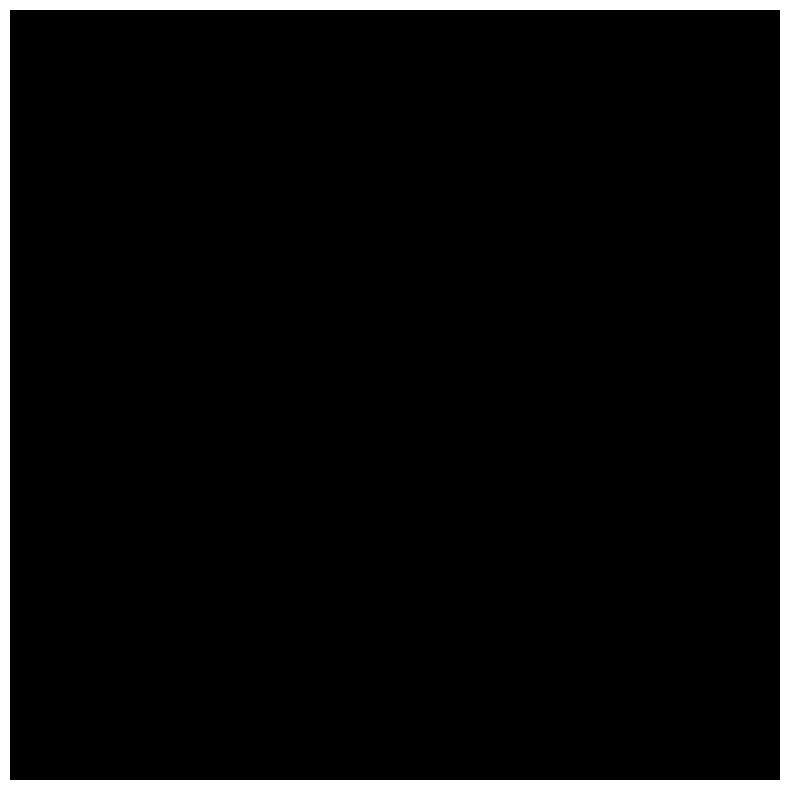

In [141]:
plot_latent_images(cvae, 10)